<a href="https://colab.research.google.com/github/chogevincent/Time_series_applying_Prophet/blob/main/Time_series_applying_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **APPLYING PROPHET IN TIME SERIES USING STUDENT PERFORMANCE DATASET**

###  **Step 1: Import Libraries**

**numpy and pandas** — for data manipulation and handling.

**seaborn and matplotlib** — for data visualization.

**prophet** — for time series forecasting.

**sklearn.metrics** — for error evaluation metrics.

**plt.style.use('fivethirtyeight')**  — applies a nice plotting style.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

### **Step 2: Load Dataset + Initial Inspection**

Loads CSV with datetime as index.

**print()** statements check:

First and last rows.

Data types and missing values.

Summary statistics (**mean, std, etc**.).

In [2]:
# Load Dataset + Create Datetime + Total Column
df = pd.read_csv('/content/StudentsPerformance1.csv', index_col=[0], parse_dates=[0])

<ipython-input-2-328bf2c35b5f>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('/content/StudentsPerformance1.csv', index_col=[0], parse_dates=[0])


In [3]:
print(df.head())

       Race/ethnicity Parental level of education         Lunch  \
Gender                                                            
female        group B           bachelor's degree      standard   
female        group C                some college      standard   
female        group B             master's degree      standard   
male          group A          associate's degree  free/reduced   
male          group C                some college      standard   

       Test preparation course  Math score  Reading score  Writing score  \
Gender                                                                     
female                    none          72             72             74   
female               completed          69             90             88   
female                    none          90             95             93   
male                      none          47             57             44   
male                      none          76             78             75  

In [4]:
print(df.tail())

       Race/ethnicity Parental level of education         Lunch  \
Gender                                                            
female        group E             master's degree      standard   
male          group C                 high school  free/reduced   
female        group C                 high school  free/reduced   
female        group D                some college      standard   
female        group D                some college  free/reduced   

       Test preparation course  Math score  Reading score  Writing score  \
Gender                                                                     
female               completed          88             99             95   
male                      none          62             55             55   
female               completed          59             71             65   
female               completed          68             78             77   
female                    none          77             86             86  

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, female to female
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Race/ethnicity               1000 non-null   object
 1   Parental level of education  1000 non-null   object
 2   Lunch                        1000 non-null   object
 3   Test preparation course      1000 non-null   object
 4   Math score                   1000 non-null   int64 
 5   Reading score                1000 non-null   int64 
 6   Writing score                1000 non-null   int64 
 7   Total                        1000 non-null   int64 
 8   Datetime                     1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 78.1+ KB
None


In [6]:
print(df.describe())

       Math score  Reading score  Writing score        Total
count  1000.00000    1000.000000    1000.000000  1000.000000
mean     66.08900      69.169000      68.054000   203.312000
std      15.16308      14.600192      15.195657    42.771978
min       0.00000      17.000000      10.000000    27.000000
25%      57.00000      59.000000      57.750000   175.000000
50%      66.00000      70.000000      69.000000   205.000000
75%      77.00000      79.000000      79.000000   233.000000
max     100.00000     100.000000     100.000000   300.000000


### **Step 3: Plot Initial Data**

Quick plot to visualize the trend of scores.

Helps you see if the data has patterns or anomalies.

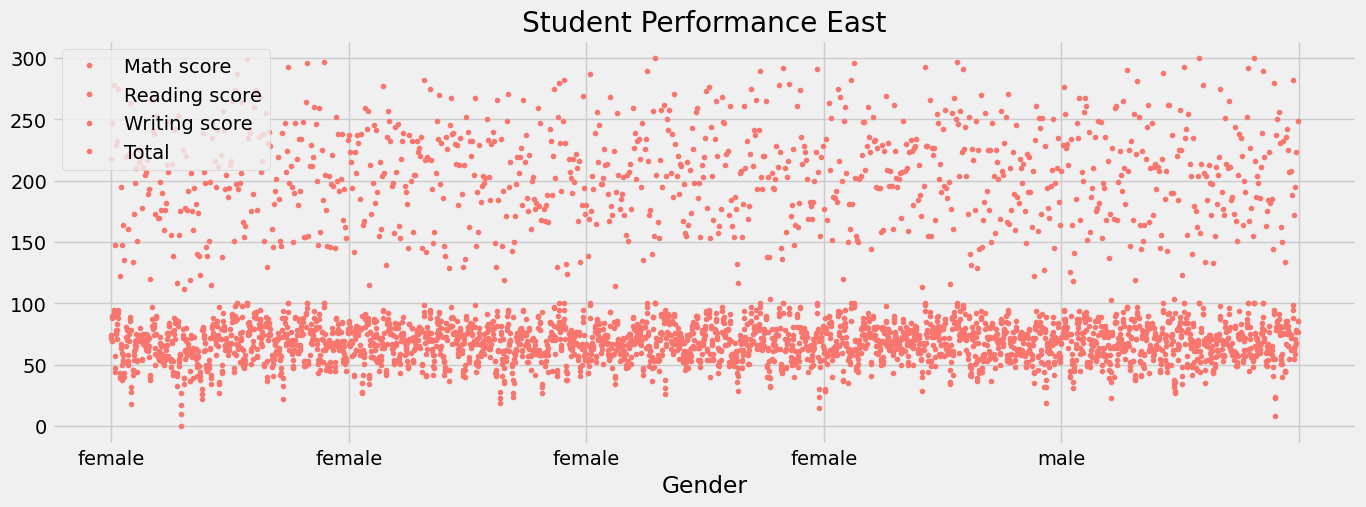

In [7]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
df.plot(style='.', figsize=(15,5), color=color_pal[0], title='Student Performance East')
plt.show()

### **Step 4: Create Synthetic Datetime + Total Score**

Creates a fake daily time index starting from **2010-01-01**.

Combines three scores into a** Total **score (target variable).

Sets **Datetime** as the dataframe index.

In [8]:
# Create synthetic datetime starting from Jan 1, 2010 with daily frequency
df['Datetime'] = pd.date_range(start='2010-01-01', periods=len(df), freq='D')

In [9]:
# Create total score as target
df['Total'] = df['Math score'] + df['Reading score'] + df['Writing score']


In [10]:
# Set datetime as index
df = df.set_index('Datetime')

### **Step 5: Visualize Target Variable**

Plot of the **Total** score across time.

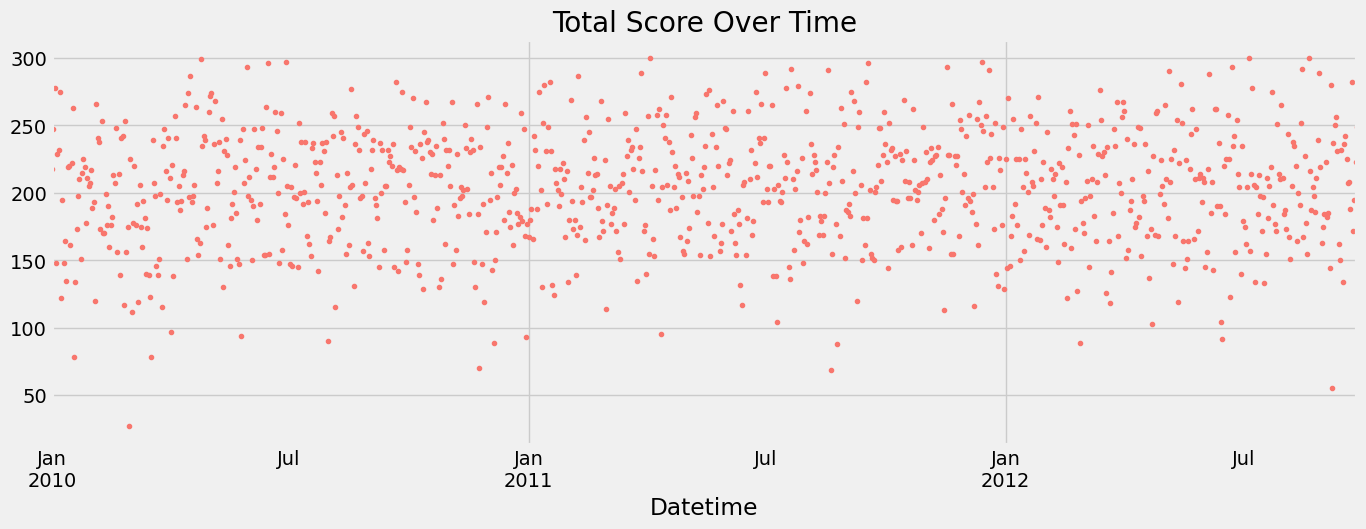

In [11]:
# Visualize Target Variable

color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

df['Total'].plot(style='.', figsize=(15,5), color=color_pal[0], title='Total Score Over Time')
plt.show()

### **Step 6: Feature Engineering**

Extracts:

    Hour, day, week, month, year, etc.

Builds a new dataset of features.

Ready for exploratory data analysis (EDA) and modeling.

In [12]:
# EDA

# Feature Engineering

def create_features(df, label=None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week

    X = df[['hour','dayofweek','quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

x, y = create_features(df, label='Total')
features_and_target = pd.concat([x, y], axis=1)
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Total
Datetime,,,,,,,,,
2010-01-01,0,4,1,1,2010,1,1,53,218
2010-01-02,0,5,1,1,2010,2,2,53,247
2010-01-03,0,6,1,1,2010,3,3,53,278
2010-01-04,0,0,1,1,2010,4,4,1,148
2010-01-05,0,1,1,1,2010,5,5,1,229


### **Step 7: EDA - Pairplot**

Visual exploration of feature relationships with **Total**.

Identifies patterns, correlations, or anomalies.

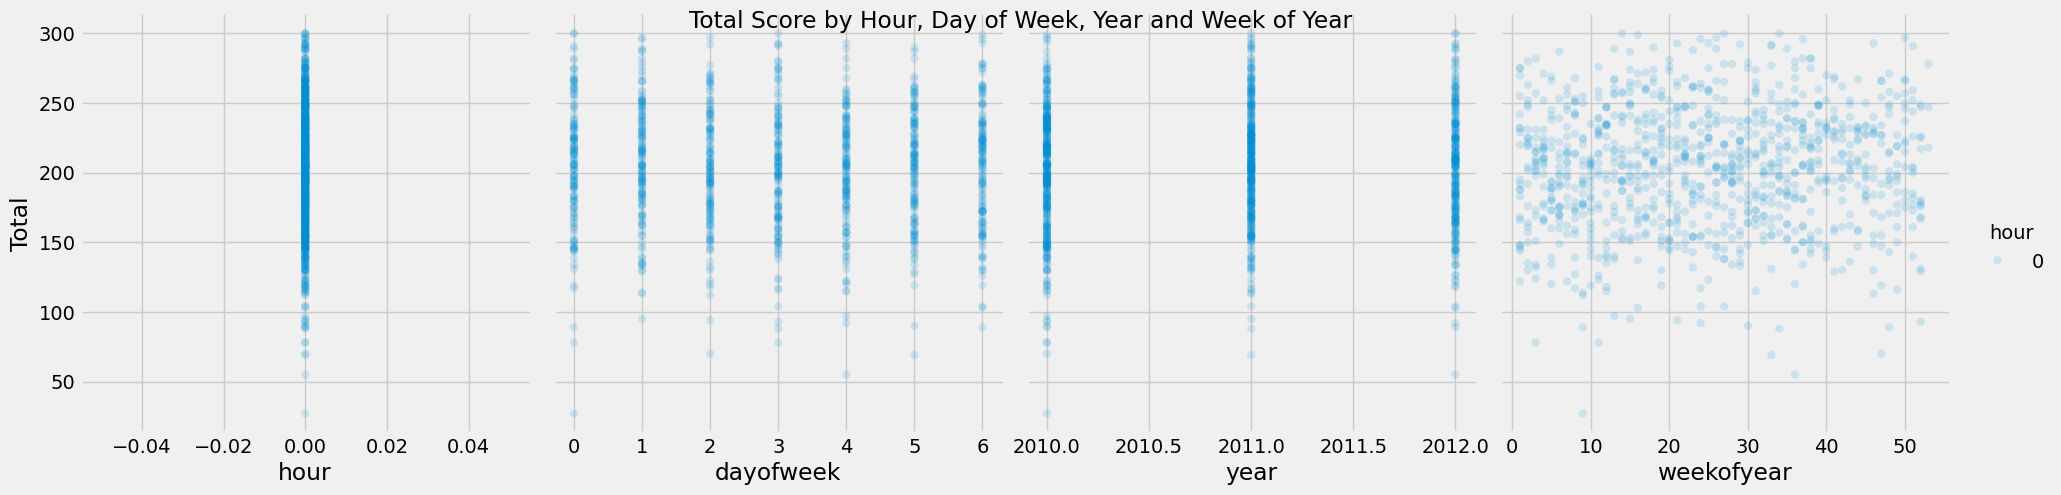

In [13]:
# EDA - Pairplot
# Plotting the Features to see trends

sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek','year','weekofyear'],
             y_vars='Total',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0})
plt.suptitle('Total Score by Hour, Day of Week, Year and Week of Year')
plt.show()

### **Step 8: Train-Test Split**

Splits the dataset into:

**train** (before or on March 10, 2010).

**test** (after March 10, 2010).

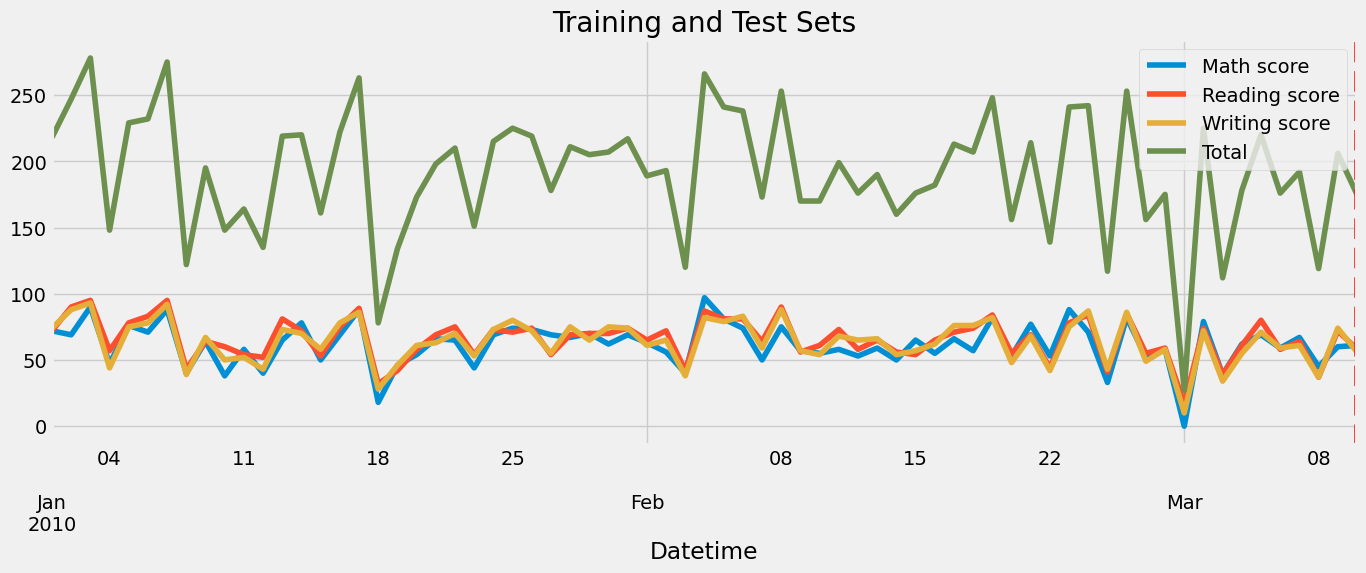

In [14]:
# Train-Test Split

split_date = '2010-03-10'
train = df.loc[df.index <= split_date].copy()
test = df.loc[df.index > split_date].copy()

train.plot(figsize=(15,5), title='Training and Test Sets')
plt.axvline(split_date, color='red', linestyle='--')
plt.show()

### **Step 9: Visualize Train vs Test Split**

Shows where the split happens.

Ensures a proper time series split.

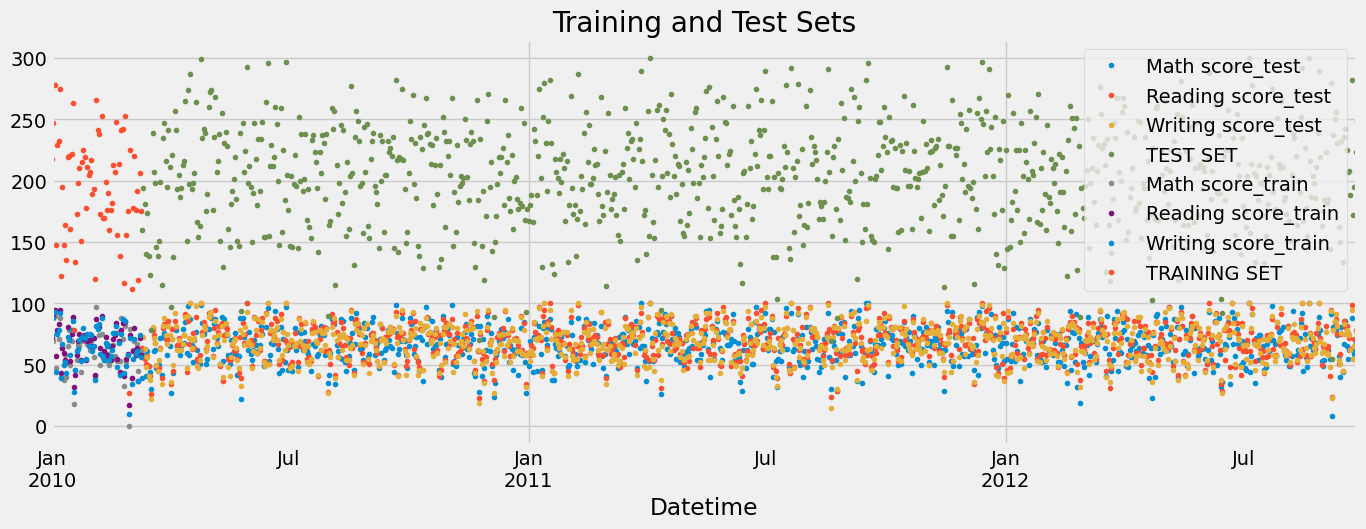

In [15]:
# Plot train and test so you can see where we have split
test \
    .rename(columns={'Total': 'TEST SET'}) \
    .join(train.rename(columns={'Total': 'TRAINING SET'}),
          how='outer', lsuffix='_test', rsuffix='_train') \
    .plot(figsize=(15,5), title='Training and Test Sets', style='.')
plt.show()

### **Step 10: Prophet Forecast Model**

Prepares data for Prophet **(ds for date, y for target).**

Trains the baseline model.

In [16]:
# Prophet Modeling

# Prophet needs columns named 'ds' and 'y'
train_df = train.reset_index().rename(columns={'Datetime':'ds', 'Total':'y'})


In [17]:
# Fit Model
model = Prophet()
model.fit(train_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp59mkktrc/dtinfaf7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp59mkktrc/yelw15l_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58433', 'data', 'file=/tmp/tmp59mkktrc/dtinfaf7.json', 'init=/tmp/tmp59mkktrc/yelw15l_.json', 'output', 'file=/tmp/tmp59mkktrc/prophet_modelwut_og_n/prophet_model-20250401212041.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:20:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:20:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### **Step 11: Make Forecast**

Predicts Total scores for the test set.

In [26]:
# Forecast

test_df = test.reset_index().rename(columns={'Datetime':'ds'})
forecast = model.predict(test_df)

In [18]:
# Checking the min and max date
# print(df.index.min())
# print(df.index.max())

In [27]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-03-11,177.106485,137.594977,245.780481,177.106485,177.106485,16.689666,16.689666,16.689666,16.689666,16.689666,16.689666,0.0,0.0,0.0,193.796151
1,2010-03-12,176.701824,134.115447,245.890466,176.701824,176.701824,13.162249,13.162249,13.162249,13.162249,13.162249,13.162249,0.0,0.0,0.0,189.864073
2,2010-03-13,176.297164,118.404592,230.014771,176.297164,176.297164,1.891217,1.891217,1.891217,1.891217,1.891217,1.891217,0.0,0.0,0.0,178.188381
3,2010-03-14,175.892503,134.263259,242.219415,175.892503,175.892503,12.066917,12.066917,12.066917,12.066917,12.066917,12.066917,0.0,0.0,0.0,187.959420
4,2010-03-15,175.487843,81.952735,194.463355,175.487842,175.487843,-39.580266,-39.580266,-39.580266,-39.580266,-39.580266,-39.580266,0.0,0.0,0.0,135.907577


### **Step 12: Plot Forecast vs Actual**

Overlay actual and predicted values.

Visually checks forecast accuracy.

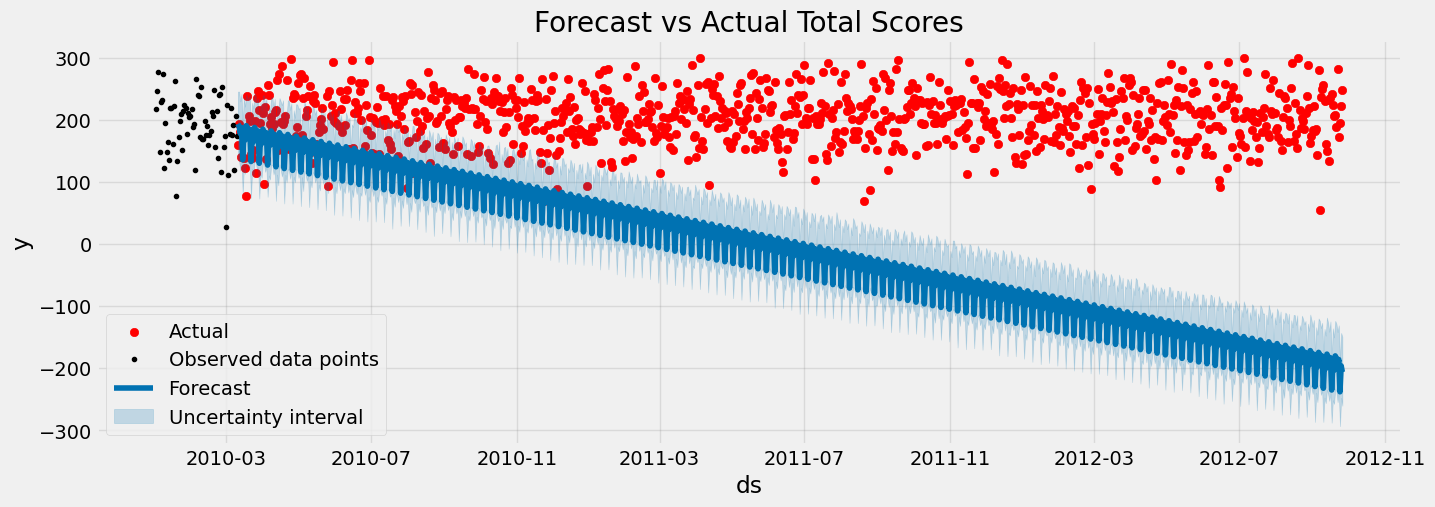

In [28]:
# Plot The Forecast

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test['Total'], color='r', label='Actual')
model.plot(forecast, ax=ax)
plt.legend()
plt.title('Forecast vs Actual Total Scores')
plt.show()

### **Step 13:  Prophet Components**

Decomposes into:

   **Trend**

   **Yearly, weekly, or daily seasonality**

   **Holiday effects (if any)**

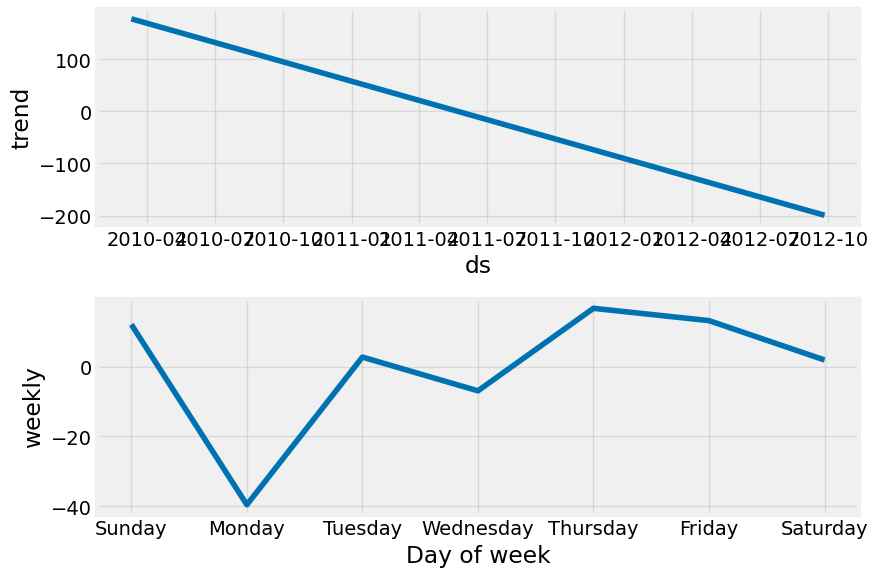

In [29]:
# Plot the components of the model
fig = model.plot_components(forecast)

### **Step 14: Forecast for Specific Date Ranges**

Zooms into specific date ranges for deeper inspection.

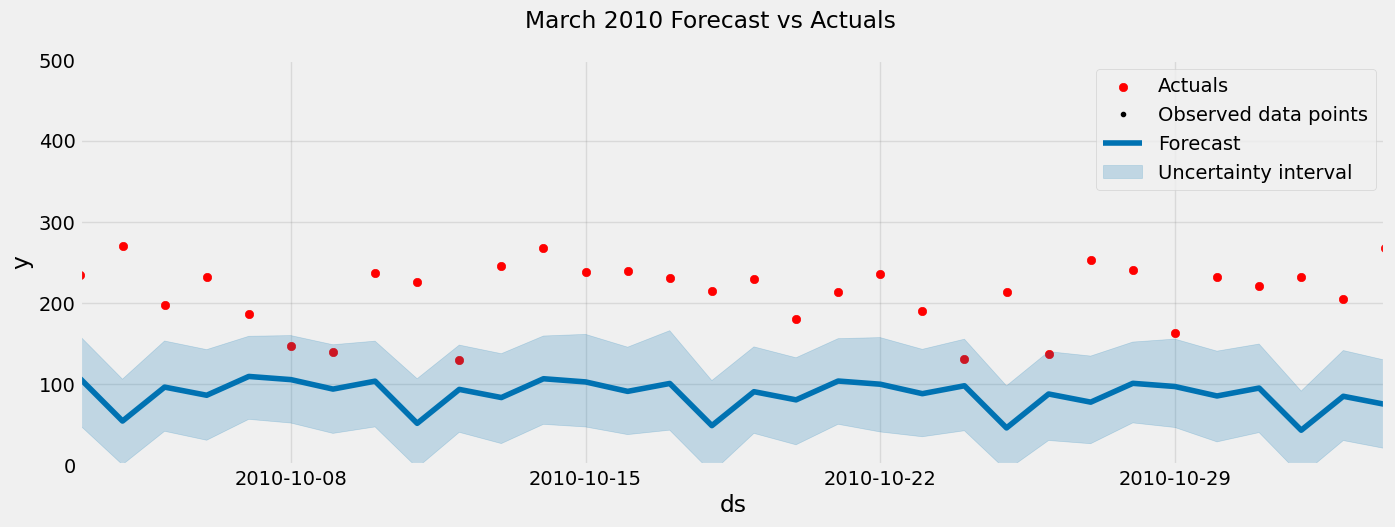

In [30]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

# Assuming pjme_test has your test data with dates as index
ax.scatter(test.index, test['Total'], color='r', label='Actuals')

# Plot the forecast
fig = model.plot(forecast, ax=ax)

# Set correct date bounds
ax.set_xbound(lower=pd.to_datetime('10-03-2010'),
              upper=pd.to_datetime('11-03-2010'))

ax.set_ylim(0, 500)  # Adjust this according to your data's y-scale

plt.legend()
plt.suptitle('March 2010 Forecast vs Actuals')
plt.show()


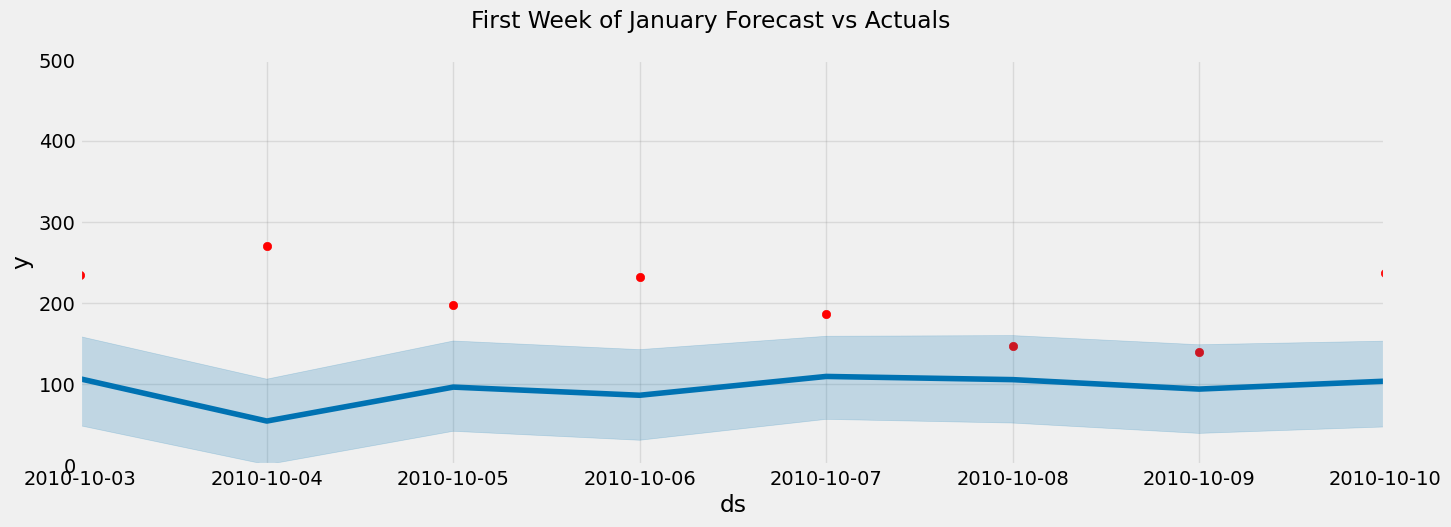

In [31]:

# Single Week of Predictions
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test['Total'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower=pd.to_datetime('10-03-2010'), upper=pd.to_datetime('10-10-2010'))
ax.set_ylim(0, 500)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

### **Step 15: Error Metrics**

Calculates:

   Mean Squared Error (MSE)

   Mean Absolute Error (MAE)

   Mean Absolute Percentage Error (MAPE)

Quantifies the forecasting error.

In [32]:
# Error Metrics

print('MSE:', mean_squared_error(test['Total'], forecast['yhat']))
print('MAE:', mean_absolute_error(test['Total'], forecast['yhat']))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAPE:', mean_absolute_percentage_error(test['Total'], forecast['yhat']))

MSE: 60578.88381834914
MAE: 216.76088325107023
MAPE: 106.62225665532993


### **Step 16: Adding US Federal Holidays**

Gets US federal holidays.

Later injected into the model to improve accuracy.

In [33]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=train.index.min(),
                              end=train.index.max())
test_holidays = cal.holidays(start=test.index.min(),
                             end=test.index.max())

In [34]:
# Create a dataframe with holiday, ds columns
# Assuming 'df' is the intended DataFrame, replace 'pjme' with 'df'
df['date'] = df.index.date
df['is_holiday'] = df.date.isin([d.date() for d in cal.holidays()])
holiday_df = df.loc[df['is_holiday']] \
    .reset_index() \
    .rename(columns={'Datetime':'ds'})  # Assuming 'Datetime' is the original index name
holiday_df['holiday'] = 'USFederalHoliday'
# Assuming columns to drop are present in 'df'
holiday_df = holiday_df.drop(['Math score', 'Reading score', 'Writing score', 'Total', 'date','is_holiday'], axis=1)
holiday_df.head()

,ds,Race/ethnicity,Parental level of education,Lunch,Test preparation course,holiday
0,2010-01-01,group B,bachelor's degree,standard,none,USFederalHoliday
1,2010-01-18,group B,some high school,free/reduced,none,USFederalHoliday
2,2010-02-15,group B,associate's degree,standard,none,USFederalHoliday
3,2010-05-31,group A,some high school,standard,completed,USFederalHoliday
4,2010-07-05,group C,associate's degree,free/reduced,completed,USFederalHoliday


**Step 17: Build Holiday Dataframe**

Creates holiday_df for Prophet.

Contains ds and holiday columns.

In [35]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

**Step 18: Prophet Model With Holidays**

Trains a second model considering holidays.

Aims to improve performance.

In [36]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(train.reset_index() \
                            .rename(columns={'Datetime':'ds',
                                             'Total':'y'}))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp59mkktrc/_7cvdi8h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp59mkktrc/8do_jpfm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65996', 'data', 'file=/tmp/tmp59mkktrc/_7cvdi8h.json', 'init=/tmp/tmp59mkktrc/8do_jpfm.json', 'output', 'file=/tmp/tmp59mkktrc/prophet_modelifgjoi7u/prophet_model-20250401212224.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:22:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:22:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### **Step 19: Forecast With Holidays**

Generates predictions with holiday information.

In [37]:
# Predict With Holidays
# Predict on training set with model
total_test_fcst_with_hols = \
    model_with_holidays.predict(df=test.reset_index() \
                                    .rename(columns={'Datetime':'ds'}))

### **Step 20: Plot Components (With Holidays)**

Shows how holidays impact the trend.

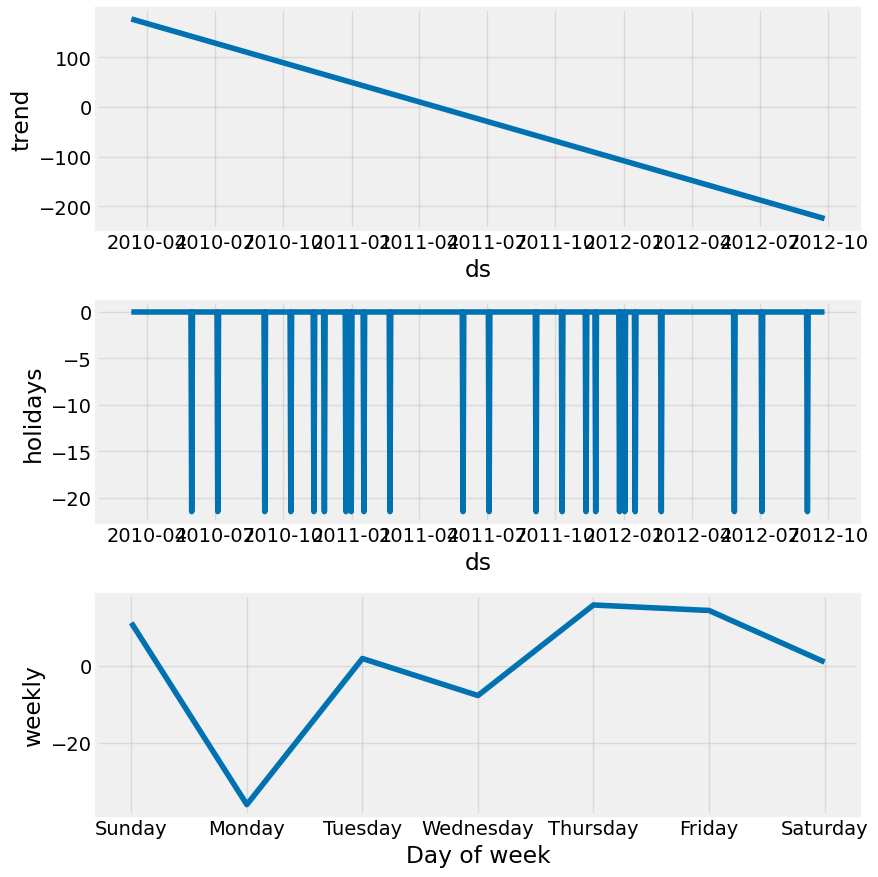

In [38]:
# Plot Holiday Effect
fig2 = model_with_holidays.plot_components(total_test_fcst_with_hols)

### **Step 21: Error Metrics After Adding Holidays**

Measures errors again to check if holidays improved results.

In [39]:
# Error Metrics with Holidays Added
mean_squared_error(y_true=test['Total'],
                   y_pred=total_test_fcst_with_hols['yhat'])

68122.67220092428

In [40]:
mean_absolute_error(y_true=test['Total'],
                   y_pred=total_test_fcst_with_hols['yhat'])

229.93990832647597

In [41]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=test['Total'],
                   y_pred=total_test_fcst_with_hols['yhat'])

np.float64(113.38635431429907)

### **Step 22: Visual Comparison**

Compares:

   Non-holiday vs holiday-aware forecasts.

<ipython-input-42-f017635a2aab>:8: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ax.set_xbound(lower=pd.to_datetime('17-03-2010'), upper=pd.to_datetime('07-10-2010'))


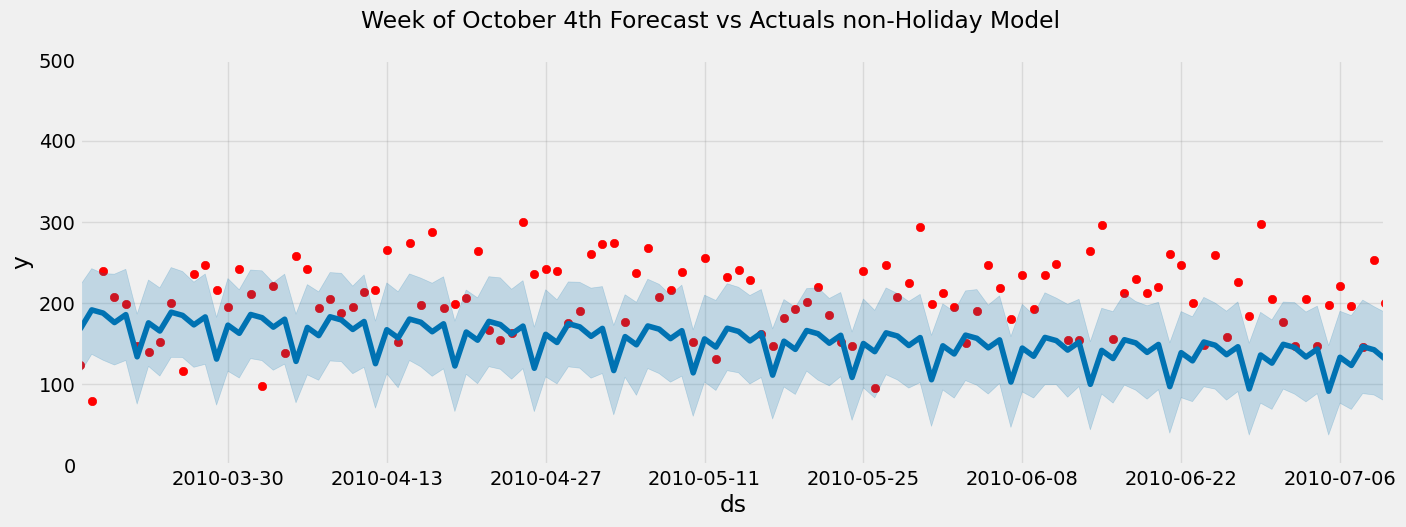

In [42]:
# Compare Models Just for Holiday Dates
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test['Total'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower=pd.to_datetime('17-03-2010'), upper=pd.to_datetime('07-10-2010'))
ax.set_ylim(0, 500)
plot = plt.suptitle('Week of October 4th Forecast vs Actuals non-Holiday Model')

<ipython-input-43-8356071e206c>:7: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ax.set_xbound(lower= pd.to_datetime('17-03-2010'), upper= pd.to_datetime('07-10-2010'))


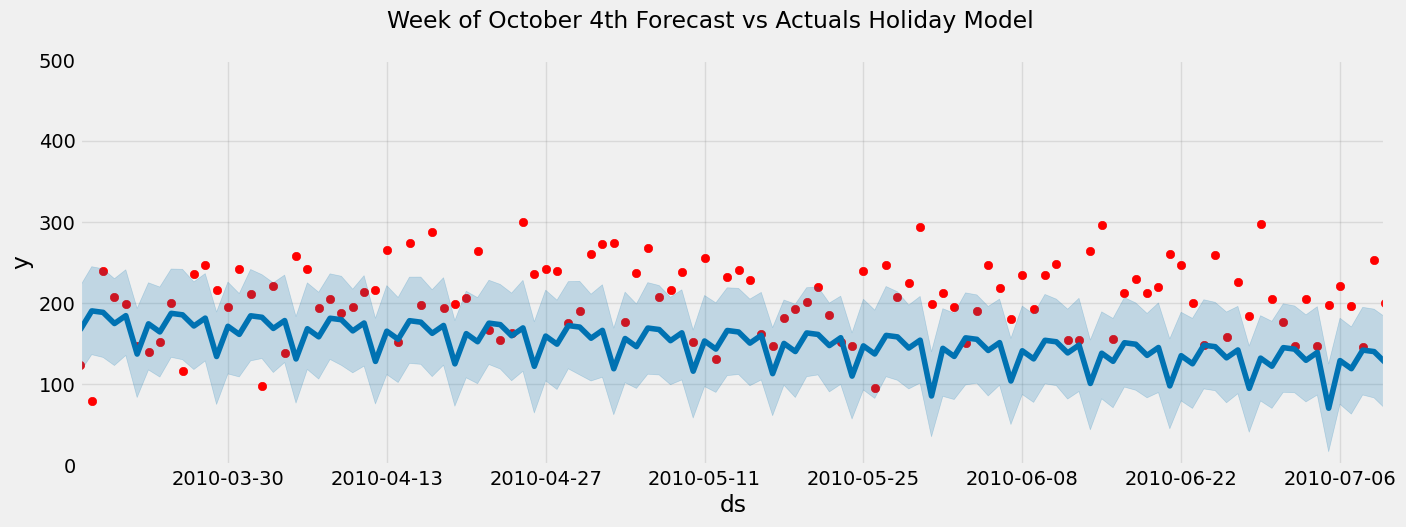

In [43]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test['Total'], color='r')
fig = model.plot(total_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower= pd.to_datetime('17-03-2010'), upper= pd.to_datetime('07-10-2010'))
ax.set_ylim(0, 500)
plot = plt.suptitle('Week of October 4th Forecast vs Actuals Holiday Model')

### **Step 23: Compare Errors on Specific Dates**

Focuses on:

   A specific date **(Oct 4th)**.

   Computes error specifically on that date.

In [44]:
# Compare Error for just 4th of October
oct4_test = test.query('Datetime >= 20160407 and Datetime < 20160408')
oct4_pred = forecast.query('ds >= 20160407 and ds < 20160408')
oct4_pred_holiday_model = total_test_fcst_with_hols.query('ds >= 20160407 and ds < 20160408')

In [45]:
# Get the first date in the test set
first_test_date = test.index.min()
# Get the day after the first date
next_day = first_test_date + pd.DateOffset(days=1)

# Filter test and forecast DataFrames
oct4_test = test[(test.index >= first_test_date) & (test.index < next_day)]
oct4_pred = forecast[(forecast['ds'] >= first_test_date) & (forecast['ds'] < next_day)]
oct4_pred_holiday_model = total_test_fcst_with_hols[(total_test_fcst_with_hols['ds'] >= first_test_date) & (total_test_fcst_with_hols['ds'] < next_day)]

# Calculate MAE
mean_absolute_error(y_true=oct4_test['Total'], y_pred=oct4_pred['yhat'])

33.79615073863633

### **Step 24: Error Over All Holidays**

Measures errors:

   Only for holiday dates.

   Compare models with/without holidays.

In [46]:
# Error of all Holidays
holiday_list = holiday_df['ds'].tolist()

In [47]:
hols_test = test.query('Datetime in @holiday_list')
hols_pred = forecast.query('ds in @holiday_list')
hols_pred_holiday_model = total_test_fcst_with_hols.query('ds in @holiday_list')

In [ ]:
mean_absolute_error(y_true=hols_test['Total'],
                   y_pred=hols_pred['yhat'])

243.10152126450177

In [48]:
mean_absolute_error(y_true=hols_test['Total'],
                   y_pred=hols_pred_holiday_model['yhat'])

275.05009984056136

### **Step 25: Error by Each Holiday**

Prints error differences:

   For each specific holiday.

   Tells you which holidays had forecasting improvements.

In [49]:
# Identify Error by holiday
holiday_df['date'] = holiday_df['ds'].dt.date

for hol, d in holiday_df.groupby('date'):
    holiday_list = d['ds'].tolist()
    hols_test = test.query('Datetime in @holiday_list')
    if len(hols_test) == 0:
        continue
    hols_pred = forecast.query('ds in @holiday_list')
    hols_pred_holiday_model = total_test_fcst_with_hols.query('ds in @holiday_list')
    non_hol_error = mean_absolute_error(y_true=hols_test['Total'],
                   y_pred=hols_pred['yhat'])
    hol_model_error = mean_absolute_error(y_true=hols_test['Total'],
                       y_pred=hols_pred_holiday_model['yhat'])
    diff = non_hol_error - hol_model_error
    print(f'Holiday: {hol:%B %d, %Y}:    \n MAE (non-holiday model): {non_hol_error:0.1f} \n MAE (Holiday Model): {hol_model_error:0.1f} \n Diff {diff:0.1f}')

Holiday: May 31, 2010:    
 MAE (non-holiday model): 93.3 
 MAE (Holiday Model): 113.3 
 Diff -20.1
Holiday: July 05, 2010:    
 MAE (non-holiday model): 106.4 
 MAE (Holiday Model): 127.4 
 Diff -21.0
Holiday: September 06, 2010:    
 MAE (non-holiday model): 125.9 
 MAE (Holiday Model): 148.7 
 Diff -22.7
Holiday: October 11, 2010:    
 MAE (non-holiday model): 175.1 
 MAE (Holiday Model): 198.8 
 Diff -23.7
Holiday: November 11, 2010:    
 MAE (non-holiday model): 103.3 
 MAE (Holiday Model): 132.6 
 Diff -29.3
Holiday: November 25, 2010:    
 MAE (non-holiday model): 145.0 
 MAE (Holiday Model): 174.6 
 Diff -29.6
Holiday: December 24, 2010:    
 MAE (non-holiday model): 103.3 
 MAE (Holiday Model): 131.6 
 Diff -28.3
Holiday: December 31, 2010:    
 MAE (non-holiday model): 106.1 
 MAE (Holiday Model): 134.6 
 Diff -28.5
Holiday: January 17, 2011:    
 MAE (non-holiday model): 270.7 
 MAE (Holiday Model): 297.1 
 Diff -26.4
Holiday: February 21, 2011:    
 MAE (non-holiday model):

### **Step 26: Visualize Forecast Residuals**

Plots:

   Forecasts.

   Actuals.

   Helps to see where the model fails.

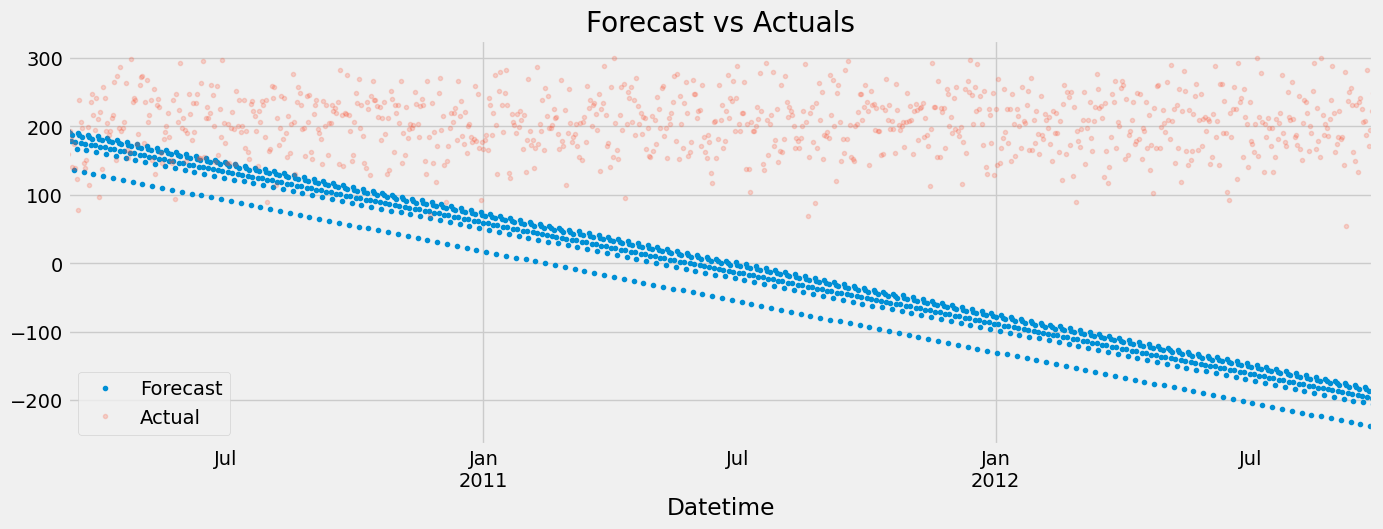

In [50]:
# Plot Error of Each Forecast
ax = forecast.set_index('ds')['yhat'].plot(figsize=(15, 5),
                                                 lw=0,
                                                 style='.')
test['Total'].plot(ax=ax,
                          style='.',
                          lw=0,
                          alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals')
plt.show()

### **Step 27: Data Cleaning: Detect Outliers**

Identifies:

   Unreasonably low values.

   Plots them in red.

Helps detect bad data

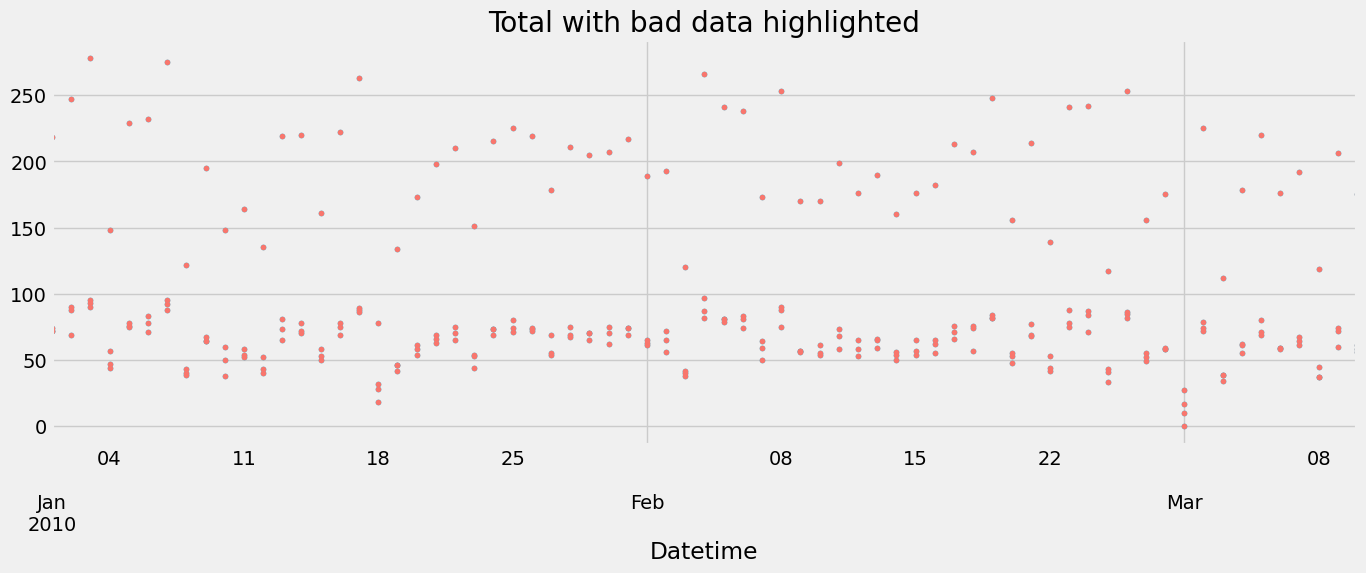

In [51]:
# Data Cleaning
# Data cleaning is a very important part of the forecasting process. If the input data contains garbage values, the forecast will use them when making predictions and could cause serious issues.
# We notice in the training data that we have some bad measurements where the values are much less. Could these be causing the under forecasting? Lets try removing this bad data.
# This plot shows the bad data highlighted in red.

ax = train.plot(style='.',
                     figsize=(15,5),
                     color=color_pal[5],
                     title='Total with bad data highlighted',
                     xlim=('01-01-2010','01-01-2011')
                    )
train.query('Total < 500').plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[0],
                                             ax=ax)
ax.legend().set_visible(False)
plt.show()

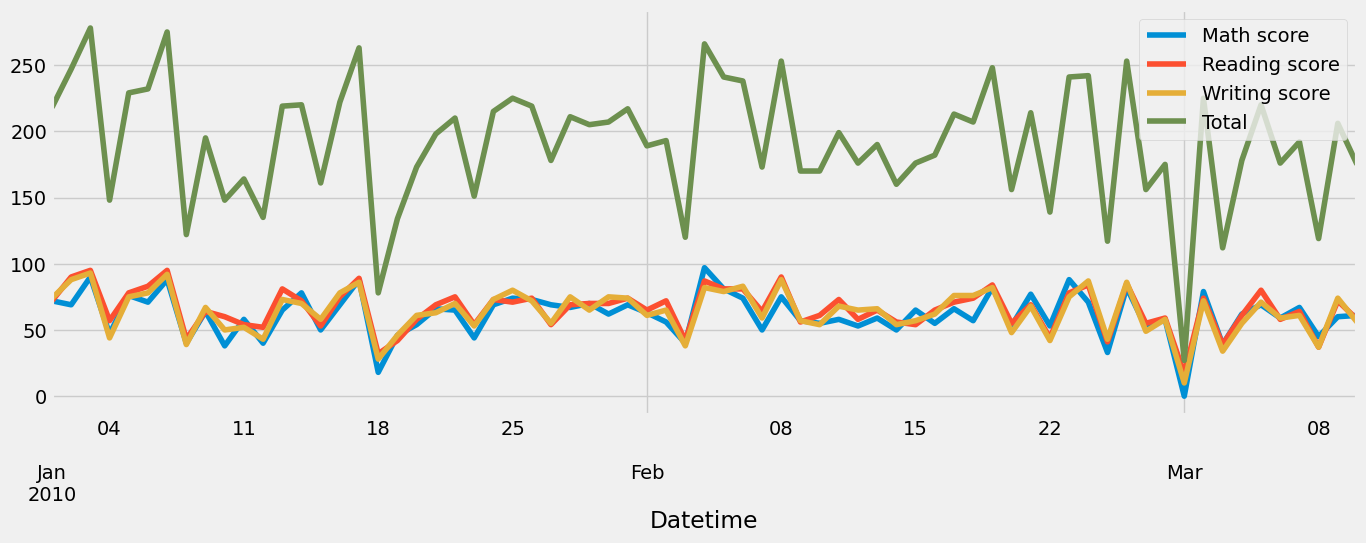

In [52]:
train.plot(figsize=(15, 5))
plt.show()

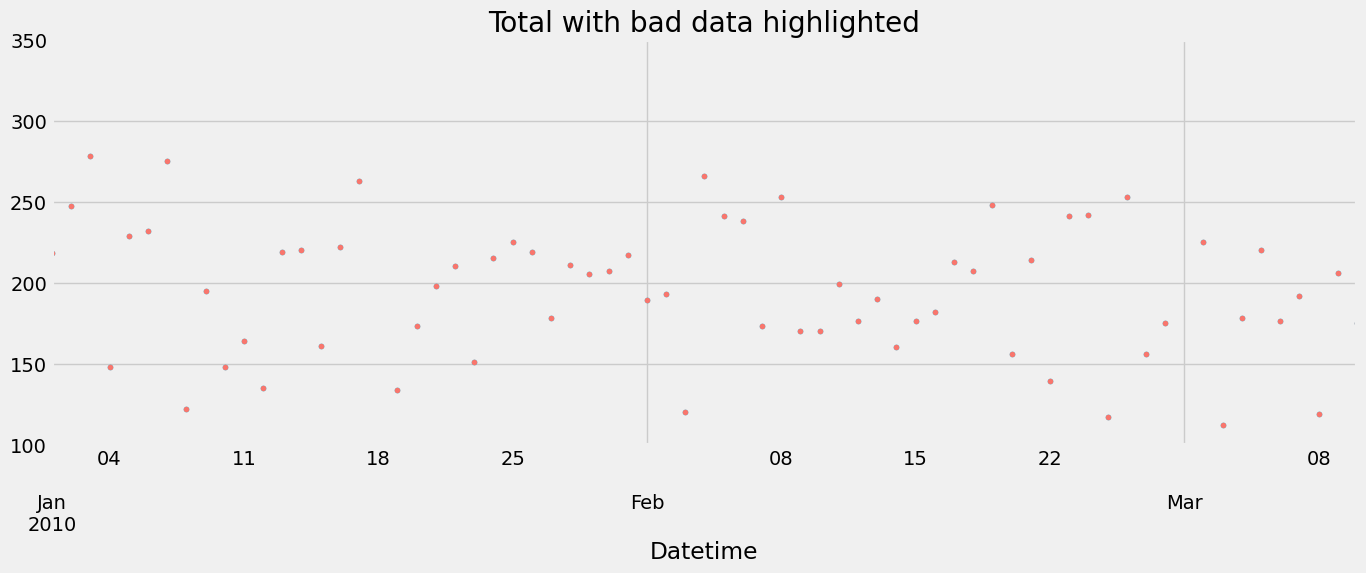

In [53]:
ax = train.plot(style='.',
                     figsize=(15,5),
                     color=color_pal[5],
                     title='Total with bad data highlighted',
                     xlim=('10-29-2010','11-01-2010'),
                     ylim=(100, 350)
                    )
train.query('Total < 480').plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[0],
                                             ax=ax)
ax.legend().set_visible(False)
plt.show()

### **Step 28: Replace Outliers**

Replaces outliers:

   Values below 480 become the 5th percentile value.

In [54]:
# Clean Data
train['total_clean'] = train['Total']

# Instead of setting to NaN, replace outliers with a less extreme value
# For example, replace values below 480 with the 5th percentile value
threshold = train['Total'].quantile(0.05)
train.loc[train['Total'] < 480, 'Total_clean'] = threshold



### **Step 29:  Train Model on Cleaned Data**

Fits model on cleaned data.

Generates new forecast.

In [55]:
# Train model on clean data
model = Prophet()
model.fit(train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'total_clean':'y'})  # Rename Total_clean to y
         )

# Predict on training set with clean model
total_test_fcst_clean = model.predict(df=test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp59mkktrc/_7z4wijm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp59mkktrc/dgco03vd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18895', 'data', 'file=/tmp/tmp59mkktrc/_7z4wijm.json', 'init=/tmp/tmp59mkktrc/dgco03vd.json', 'output', 'file=/tmp/tmp59mkktrc/prophet_modellj4mv5ju/prophet_model-20250401212356.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:23:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:23:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### **Step 30: Evaluate Clean Model**

Re-calculates:

   MSE

   MAE

   MAPE

Shows if cleaning helped.

In [56]:
# After cleaning we see a slight improvement in score compared to the first model. More data cleaning, along with holidays could yield even better results. Give it a try!

mse_clean = mean_squared_error(y_true=test['Total'],
                               y_pred=total_test_fcst_clean['yhat']
                              )
mae_clean = mean_absolute_error(y_true=test['Total'],
                                y_pred=total_test_fcst_clean['yhat']
                               )
mape_clean = mean_absolute_percentage_error(y_true=test['Total'],
                                            y_pred=total_test_fcst_clean['yhat'])
print(f'Cleaned data model has MSE {mse_clean:0.4f} - MAE {mae_clean:0.4f} - MAPE {mape_clean:0.4f}')

Cleaned data model has MSE 60578.8838 - MAE 216.7609 - MAPE 106.6223


### **Step 31: Final Plot of Clean Model**

Final plot comparing:

   Clean model's forecast vs actuals.

   Should show improvement.

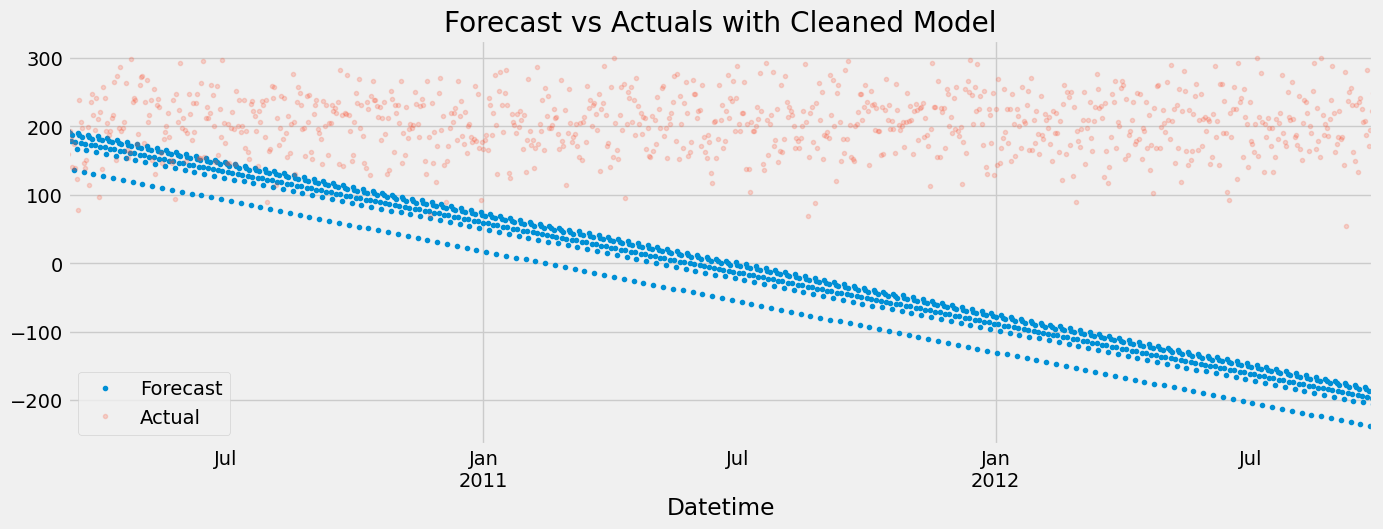

In [57]:
ax = total_test_fcst_clean.set_index('ds')['yhat'] \
    .plot(figsize=(15, 5), lw=0, style='.')
test['Total'].plot(ax=ax, style='.', lw=0, alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals with Cleaned Model')
plt.show()